In [1]:
import pandas as pd
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.vecm import VECM
# For error calculation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import f_regression

import random
import numpy as np

import xgboost as xgb

import shap
import lime

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)

## Reusable Functions

In [2]:
def filter_data(df_data, tickers, date, data_lookback = 60):
    # Function to calculate start date from a given date
    sdate = lambda x: (pd.to_datetime(x) - datetime.timedelta(days = 30 * data_lookback)).strftime('%Y%m%d')    
    #print(sdate(date))
    #print(datetime.timedelta(days = 30 * data_lookback))
    # Create subset for only the applicable tickers
    df_subset = df_data.loc[sdate(date):date][tickers]
    #print(df_subset)
    #Eliminate any tickers that have NaNs as some or all values
    for col in df_subset.columns:    
        # count NaN occurences     
        count_null = df_subset[col].isnull().sum()
        if count_null == 0:
            continue
        else:
            df_subset.drop(columns = col, inplace = True)
            #print('Dropped: ', col) 
            
    return df_subset

In [3]:
def train_model(X_train_transformed, X_test, n_obs = 5, verbose = False):
    
     # Train model
    model = VECM(X_train_transformed)
    res = model.fit()
    #res = model.fit(15)

    lag_order = res.k_ar

    if verbose == True:
        print("Lag samples to use for future predictions : ", lag_order)
        
    # forecasting
    if lag_order > 0:
        pred = res.predict(steps=n_obs)
        pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))   

        # Save coefficients to their own df
        #df_coef = pd.DataFrame(zip(X_train_transformed.columns, (res.coefs.mean(axis=2).flatten())), columns = ['ticker', 'coef']).sort_values('coef', ascending = False).reset_index(drop = True)

        return pred, None, lag_order, res
    else:
        return None, None, None, None

In [4]:
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

In [5]:
def make_predictions(X_train, pred, X_test):

    # Invert transform to get actual numerical predictions
    output = invert_transformation(X_train, pred)  

    #combining predicted and real data set
    combine_csi1_x = pd.concat([output['csi1_pred'], X_test['csi1']], axis=1)
    combine_csi1_x['accuracy'] = round(combine_csi1_x.apply(lambda row: row.csi1_pred /row.csi1 *100, axis = 1),2)
    combine_csi1_x['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine_csi1_x['accuracy']],index = combine_csi1_x.index)
    combine_csi1_x = combine_csi1_x.round(decimals=2).reset_index()
    combine_csi1_x = combine_csi1_x.sort_values(by='date', ascending=False)

    #Forecast bias
    forecast_errors = [combine_csi1_x['csi1'][i]- combine_csi1_x['csi1_pred'][i] for i in range(len(combine_csi1_x['csi1']))]
    bias = sum(forecast_errors) * 1.0/len(combine_csi1_x['csi1'])
    MSE = mean_squared_error(combine_csi1_x['csi1'].values, combine_csi1_x['csi1_pred'].values)
    #     print('Bias: %f' % bias)
    #     print('Mean absolute error:', mean_absolute_error(combine_csi1_x['csi1'].values, combine_csi1_x['csi1_pred'].values))
    #     print('Mean squared error:', MSE)
    #     print('Root mean squared error:', np.sqrt(mean_squared_error(combine_csi1_x['csi1'].values, combine_csi1_x['csi1_pred'].values)))

    return combine_csi1_x, MSE

## Load Data

In [6]:
# Setup one year of CSI prediction using all the possible methods 

# AIC, etc, etc, 
# Varying lag periods 

# Create ability to pull out Standard Errors if lag period chosen is greater than 1

csi_data = pd.read_csv("csi_data.csv").drop(columns=["csi2", "difference"])
tickers = pd.read_csv("SP500_tickers.csv")
stock_data = pd.read_csv("stock_data.csv")

tickers_final = [ticker for ticker in tickers.ticker if ticker in stock_data.columns]

print("List of Tickers in Stock Data : ", len(tickers_final))

stock_data =  stock_data[tickers_final]

df_data = pd.concat((csi_data, stock_data), axis=1)
print(df_data.shape)

# Bring in data
#df_data = pd.read_csv('_data/df_data_regular')
df_data['date'] = df_data.apply(lambda x: pd.to_datetime(x['date']), axis = 1)
df_data.set_index('date', inplace = True)

print(df_data.shape)

df_data.head()

List of Tickers in Stock Data :  471
(3523, 473)
(3523, 472)


,csi1,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JNJ,V,PG,JPM,UNH,HD,MA,NVDA,VZ,PYPL,PFE,NFLX,ADBE,T,DIS,INTC,MRK,CMCSA,CSCO,BAC,PEP,KO,WMT,ABT,XOM,CRM,ABBV,TMO,CVX,MCD,AMGN,COST,ACN,NEE,BMY,MDT,LLY,DHR,LIN,AVGO,PM,QCOM,NKE,TXN,UNP,AMT,ORCL,LOW,IBM,C,HON,UPS,LMT,WFC,GILD,AMD,FIS,SBUX,BLK,MMM,BA,CHTR,SPGI,CVS,NOW,BDX,ISRG,MDLZ,INTU,MO,PLD,CAT,VRTX,CCI,ZTS,ANTM,BKNG,EQIX,D,CI,CL,SYK,REGN,ATVI,APD,AXP,TGT,DUK,TJX,GS,TMUS,MMC,AMAT,MS,CB,SO,CME,ADP,FISV,MU,ILMN,DE,BSX,LRCX,GE,CSX,ITW,NEM,GPN,HUM,SHW,KMB,ICE,ADSK,PGR,NOC,USB,TFC,EW,DG,NSC,AON,ECL,MCO,PNC,BIIB,ROP,BAX,EL,ADI,DLR,WM,AEP,FDX,COP,EA,DXCM,DD,CNC,SCHW,GIS,ETN,CTSH,EMR,LHX,EXC,SRE,EBAY,XEL,ORLY,SBAC,GD,HCA,INFO,IDXX,MSCI,ROST,GM,KLAC,APH,DOW,TROW,ES,VRSK,STZ,SNPS,CDNS,WBA,WEC,TEL,A,COF,PSA,TRV,CMG,MET,MNST,RMD,PCAR,ALL,BK,CLX,TWTR,CMI,IQV,ZBH,AZO,JCI,KMI,YUM,PSX,AIG,KR,XLNX,SYY,WLTW,EOG,FAST,ANSS,AWK,F,PRU,ED,PPG,SLB,AFL,ROK,MCHP,CTAS,MCK,HPQ,MPC,ADM,BLL,GLW,SWK,MSI,SWKS,MKC,WMB,ALXN,MAR,PH,VLO,PAYX,WELL,BBY,STT,ARE,DLTR,DHI,CHD,DTE,FLT,MTD,CERN,VRSN,HSY,TDG,HLT,KHC,CTVA,FTV,ALGN,AME,AVB,WY,EIX,ETR,O,APTV,PPL,LEN,AJG,WST,EFX,SPG,MKTX,VFC,AEE,CPRT,FRC,LH,EQR,FCX,AMP,MXIM,KEYS,FTNT,RSG,TSN,CAG,HOLX,AKAM,TTWO,TFX,INCY,K,ODFL,TSCO,DGX,LYB,CDW,NTRS,CAH,LUV,CTXS,KMX,PXD,DFS,VMC,FE,LVS,ABC,BR,DOV,MAS,QRVO,KSU,NDAQ,ZBRA,GWW,DPZ,HIG,GRMN,ESS,DAL,VTR,HRL,EXPD,OXY,IP,PAYC,FITB,MTB,TYL,VIAC,COO,STE,FMC,JKHY,ANET,ABMD,TIF,XYL,MAA,IFF,WAT,EXR,GPC,PKI,MLM,NUE,HAL,BXP,CHRW,ATO,VAR,WDC,SYF,HPE,SJM,HES,LDOS,IEX,CINF,KEY,OKE,CE,EXPE,SIVB,OMC,ETFC,WAB,NLOK,BIO,ULTA,URI,TDY,PHM,IT,J,JBHT,IR,FBHS,AAP,CNP,RF,STX,EMN,DRI,WHR,AES,WU,CXO,HSIC,XRAY,BKR,NTAP,CBOE,HBAN,AVY,HAS,CTL,PNW,PKG,ALLE,NI,FOXA,WRB,LKQ,UHS,ALB,RE,LW,RCL,NRG,MGM,RJF,DISH,MYL,JNPR,CPB,DVA,TXT,IRM,FFIV,UAL,GL,SNA,HST,BWA,PRGO,COG,WYNN,LNC,WRK,HII,IPG,TAP,CCL,NWL,CF,LYV,IPGP,AIZ,FANG,APA,PWR,ZION,SEE,AAL,CMA,FLIR,LB,FRT,HBI,LEG,NLSN,PBCT,MHK,NBL,NWSA,MOS,DXC,MRO,NOV,ALK,DVN,HFC,SLG,IVZ,PVH,TPR,NCLH,RL,FTI,DISCA,KSS,XRX,GPS,HRB,UAA,UA,COTY
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.0,0.084282,0.211839,0.375533,NaN,1.719281,1.711147,0.486425,NaN,0.463931,0.317206,0.487214,0.325493,NaN,0.100552,0.215639,NaN,0.187687,0.029372,0.304025,0.195028,0.189981,0.201815,0.258485,0.069008,0.137727,0.371586,0.471665,0.161405,0.364878,0.149772,0.461484,0.067561,NaN,0.238990,0.466298,0.264562,0.634254,0.394002,0.231255,0.331965,0.183425,0.456590,0.452723,0.168624,0.424862,NaN,NaN,0.347277,0.084797,0.262352,0.158149,0.215470,0.099448,0.264680,0.647672,3.890292,0.281872,0.596290,0.501579,0.251776,0.107932,0.255722,0.323915,0.121823,0.860300,0.624388,0.555959,NaN,0.408998,0.207972,NaN,0.477111,0.304657,0.221389,0.213418,0.591792,0.392660,0.456196,0.220205,0.212313,NaN,0.626362,0.179006,0.326993,0.312391,0.295449,0.216693,0.352013,0.125493,0.055012,0.435228,0.414996,0.431886,0.383058,0.045679,1.017127,NaN,0.251618,0.144672,0.460221,0.430466,0.276796,0.573054,0.289997,0.086208,0.106630,0.058445,0.268350,0.193054,0.289582,0.268426,0.065706,0.353512,0.450987,0.187135,0.440253,0.356669,0.449647,0.059763,0.337411,0.227940,0.425223,0.238990,0.333938,0.027230,NaN,0.342936,0.294002,0.281768,0.496922,0.501657,0.368903,0.312155,0.164455,0.131571,0.289661,0.179558,0.242068,0.294870,0.815470,0.364071,0.420994,0.114444,0.493483,0.052190,0.118074,0.195659,0.265312,0.099980,0.296488,0.327213,0.431097,0.364167,0.147688,0.146567,0.252486,0.145383,0.453828,NaN,NaN,0.142798,NaN,0.058090,NaN,0.400079,0.087747,NaN,0.288043,0.156275,NaN,0.205130,0.161484,0.133781,0.358248,0.157459,NaN,0.189130,0.686504,0.552170,0.362983,NaN,0.355381,0.027269,0.15082

In [7]:
df_data.tail()

,csi1,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JNJ,V,PG,JPM,UNH,HD,MA,NVDA,VZ,PYPL,PFE,NFLX,ADBE,T,DIS,INTC,MRK,CMCSA,CSCO,BAC,PEP,KO,WMT,ABT,XOM,CRM,ABBV,TMO,CVX,MCD,AMGN,COST,ACN,NEE,BMY,MDT,LLY,DHR,LIN,AVGO,PM,QCOM,NKE,TXN,UNP,AMT,ORCL,LOW,IBM,C,HON,UPS,LMT,WFC,GILD,AMD,FIS,SBUX,BLK,MMM,BA,CHTR,SPGI,CVS,NOW,BDX,ISRG,MDLZ,INTU,MO,PLD,CAT,VRTX,CCI,ZTS,ANTM,BKNG,EQIX,D,CI,CL,SYK,REGN,ATVI,APD,AXP,TGT,DUK,TJX,GS,TMUS,MMC,AMAT,MS,CB,SO,CME,ADP,FISV,MU,ILMN,DE,BSX,LRCX,GE,CSX,ITW,NEM,GPN,HUM,SHW,KMB,ICE,ADSK,PGR,NOC,USB,TFC,EW,DG,NSC,AON,ECL,MCO,PNC,BIIB,ROP,BAX,EL,ADI,DLR,WM,AEP,FDX,COP,EA,DXCM,DD,CNC,SCHW,GIS,ETN,CTSH,EMR,LHX,EXC,SRE,EBAY,XEL,ORLY,SBAC,GD,HCA,INFO,IDXX,MSCI,ROST,GM,KLAC,APH,DOW,TROW,ES,VRSK,STZ,SNPS,CDNS,WBA,WEC,TEL,A,COF,PSA,TRV,CMG,MET,MNST,RMD,PCAR,ALL,BK,CLX,TWTR,CMI,IQV,ZBH,AZO,JCI,KMI,YUM,PSX,AIG,KR,XLNX,SYY,WLTW,EOG,FAST,ANSS,AWK,F,PRU,ED,PPG,SLB,AFL,ROK,MCHP,CTAS,MCK,HPQ,MPC,ADM,BLL,GLW,SWK,MSI,SWKS,MKC,WMB,ALXN,MAR,PH,VLO,PAYX,WELL,BBY,STT,ARE,DLTR,DHI,CHD,DTE,FLT,MTD,CERN,VRSN,HSY,TDG,HLT,KHC,CTVA,FTV,ALGN,AME,AVB,WY,EIX,ETR,O,APTV,PPL,LEN,AJG,WST,EFX,SPG,MKTX,VFC,AEE,CPRT,FRC,LH,EQR,FCX,AMP,MXIM,KEYS,FTNT,RSG,TSN,CAG,HOLX,AKAM,TTWO,TFX,INCY,K,ODFL,TSCO,DGX,LYB,CDW,NTRS,CAH,LUV,CTXS,KMX,PXD,DFS,VMC,FE,LVS,ABC,BR,DOV,MAS,QRVO,KSU,NDAQ,ZBRA,GWW,DPZ,HIG,GRMN,ESS,DAL,VTR,HRL,EXPD,OXY,IP,PAYC,FITB,MTB,TYL,VIAC,COO,STE,FMC,JKHY,ANET,ABMD,TIF,XYL,MAA,IFF,WAT,EXR,GPC,PKI,MLM,NUE,HAL,BXP,CHRW,ATO,VAR,WDC,SYF,HPE,SJM,HES,LDOS,IEX,CINF,KEY,OKE,CE,EXPE,SIVB,OMC,ETFC,WAB,NLOK,BIO,ULTA,URI,TDY,PHM,IT,J,JBHT,IR,FBHS,AAP,CNP,RF,STX,EMN,DRI,WHR,AES,WU,CXO,HSIC,XRAY,BKR,NTAP,CBOE,HBAN,AVY,HAS,CTL,PNW,PKG,ALLE,NI,FOXA,WRB,LKQ,UHS,ALB,RE,LW,RCL,NRG,MGM,RJF,DISH,MYL,JNPR,CPB,DVA,TXT,IRM,FFIV,UAL,GL,SNA,HST,BWA,PRGO,COG,WYNN,LNC,WRK,HII,IPG,TAP,CCL,NWL,CF,LYV,IPGP,AIZ,FANG,APA,PWR,ZION,SEE,AAL,CMA,FLIR,LB,FRT,HBI,LEG,NLSN,PBCT,MHK,NBL,NWSA,MOS,DXC,MRO,NOV,ALK,DVN,HFC,SLG,IVZ,PVH,TPR,NCLH,RL,FTI,DISCA,KSS,XRX,GPS,HRB,UAA,UA,COTY
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-24,1.437937,0.884942,0.489929,5.569872,0.638546,4.185257,4.182548,0.454285,0.583912,0.389814,0.428291,0.916913,0.686953,0.926065,0.742832,0.190767,0.338356,0.122311,1.037263,1.026181,0.121284,0.452293,0.184945,0.284656,0.138623,0.148741,0.109641,0.426143,0.170314,0.372039,0.271706,0.217975,0.508203,0.279706,1.016437,0.374623,0.612240,0.754382,0.915948,0.658749,0.748716,0.196619,0.354170,0.408150,0.477353,0.658780,0.997727,0.268063,0.276344,0.311739,0.400118,0.560004,0.706908,0.166361,0.372848,0.420197,0.244653,0.548859,0.368365,1.214613,0.167543,0.207702,0.144881,0.429225,0.275566,1.555396,0.550011,1.036640,1.496934,0.848302,0.231952,0.884724,0.849889,1.864116,0.171186,0.822868,0.156523,0.273511,0.459110,0.686611,0.435949,0.413784,0.947919,6.363042,1.784516,0.253276,0.635090,0.213399,0.658656,1.172089,0.183078,0.731719,0.388320,0.400181,0.280889,0.187965,0.715718,0.240700,0.347321,0.191452,0.157800,0.479220,0.196526,0.633067,0.528936,0.363073,0.172524,1.044392,0.543224,0.141052,0.916726,0.034835,0.227189,0.560906,0.131308,0.569187,1.146655,1.809109,0.427202,0.286991,0.572518,0.223734,1.080472,0.185755,0.174828,0.244674,0.486412,0.606762,0.646577,0.595990,0.741462,0.499393,0.946580,1.099648,0.263643,0.639573,0.372692,0.363416,0.350528,0.292127,0.469383,0.201320,0.337920,0.673661,0.198549,0.196837,0.151636,0.164929,0.294119,0.194253,0.236902,0.626405,0.141083,0.468979,0.112723,0.195685,1.369206,0.747595,0.556673,0.460667,0.233882,0.819537,0.810510,0.358373,0.113875,0.554463,0.333811,0.170906,0.380413,0.261370,0.464371,0.581608,0.430252,0

In [8]:
total_snp_tickers = df_data.columns[1:].tolist()

print(total_snp_tickers)

['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'JNJ', 'V', 'PG', 'JPM', 'UNH', 'HD', 'MA', 'NVDA', 'VZ', 'PYPL', 'PFE', 'NFLX', 'ADBE', 'T', 'DIS', 'INTC', 'MRK', 'CMCSA', 'CSCO', 'BAC', 'PEP', 'KO', 'WMT', 'ABT', 'XOM', 'CRM', 'ABBV', 'TMO', 'CVX', 'MCD', 'AMGN', 'COST', 'ACN', 'NEE', 'BMY', 'MDT', 'LLY', 'DHR', 'LIN', 'AVGO', 'PM', 'QCOM', 'NKE', 'TXN', 'UNP', 'AMT', 'ORCL', 'LOW', 'IBM', 'C', 'HON', 'UPS', 'LMT', 'WFC', 'GILD', 'AMD', 'FIS', 'SBUX', 'BLK', 'MMM', 'BA', 'CHTR', 'SPGI', 'CVS', 'NOW', 'BDX', 'ISRG', 'MDLZ', 'INTU', 'MO', 'PLD', 'CAT', 'VRTX', 'CCI', 'ZTS', 'ANTM', 'BKNG', 'EQIX', 'D', 'CI', 'CL', 'SYK', 'REGN', 'ATVI', 'APD', 'AXP', 'TGT', 'DUK', 'TJX', 'GS', 'TMUS', 'MMC', 'AMAT', 'MS', 'CB', 'SO', 'CME', 'ADP', 'FISV', 'MU', 'ILMN', 'DE', 'BSX', 'LRCX', 'GE', 'CSX', 'ITW', 'NEM', 'GPN', 'HUM', 'SHW', 'KMB', 'ICE', 'ADSK', 'PGR', 'NOC', 'USB', 'TFC', 'EW', 'DG', 'NSC', 'AON', 'ECL', 'MCO', 'PNC', 'BIIB', 'ROP', 'BAX', 'EL', 'ADI', 'DLR', 'WM', 'AEP', 'FDX', 'COP', 'E

### Loading Causality Matrix

In [9]:
gc_test = pd.read_csv('CSI_SP500_granger_causality_FULL.csv', index_col = 0) # I ran the function previously (it took a long time)
print("Dataset Size : ", gc_test.shape)
gc_test.head()

Dataset Size :  (403, 403)


,A_x,AAL_x,AAP_x,AAPL_x,ABC_x,ABMD_x,ABT_x,ACN_x,ADBE_x,ADI_x,ADM_x,ADP_x,ADSK_x,AEE_x,AEP_x,AES_x,AFL_x,AIG_x,AIZ_x,AJG_x,AKAM_x,ALB_x,ALGN_x,ALK_x,ALL_x,ALXN_x,AMAT_x,AMD_x,AME_x,AMGN_x,AMP_x,AMT_x,AMZN_x,ANSS_x,ANTM_x,AON_x,APA_x,APD_x,APH_x,ARE_x,ATO_x,ATVI_x,AVB_x,AVY_x,AXP_x,AZO_x,BA_x,BAC_x,BAX_x,BBY_x,BDX_x,BIIB_x,BIO_x,BK_x,BKNG_x,BKR_x,BLK_x,BLL_x,BMY_x,BSX_x,BWA_x,BXP_x,C_x,CAG_x,CAH_x,CAT_x,CB_x,CCI_x,CCL_x,CDNS_x,CE_x,CERN_x,CF_x,CHD_x,CHRW_x,CI_x,CINF_x,CL_x,CLX_x,CMA_x,CMCSA_x,CME_x,CMI_x,CNC_x,CNP_x,COF_x,COG_x,COO_x,COP_x,COST_x,CPB_x,CPRT_x,CRM_x,CSCO_x,CSX_x,CTAS_x,CTL_x,CTSH_x,CTXS_x,CVS_x,CVX_x,D_x,DD_x,DE_x,DGX_x,DHI_x,DHR_x,DIS_x,DISCA_x,DISH_x,DLR_x,DLTR_x,DOV_x,DPZ_x,DRI_x,DTE_x,DUK_x,DVA_x,DVN_x,DXC_x,DXCM_x,EA_x,EBAY_x,ECL_x,ED_x,EFX_x,EIX_x,EL_x,EMN_x,EMR_x,EOG_x,EQIX_x,EQR_x,ES_x,ESS_x,ETFC_x,ETN_x,ETR_x,EW_x,EXC_x,EXPD_x,EXPE_x,EXR_x,F_x,FAST_x,FCX_x,FDX_x,FE_x,FFIV_x,FIS_x,FISV_x,FITB_x,FLIR_x,FMC_x,FRT_x,FTI_x,GD_x,GE_x,GILD_x,GIS_x,GL_x,GLW_x,GOOG_x,GOOGL_x,GPC_x,GPN_x,GPS_x,GRMN_x,GS_x,GWW_x,HAL_x,HAS_x,HBAN_x,HD_x,HES_x,HFC_x,HIG_x,HOLX_x,HON_x,HPQ_x,HRB_x,HRL_x,HSIC_x,HST_x,HSY_x,HUM_x,IBM_x,ICE_x,IDXX_x,IEX_x,IFF_x,ILMN_x,INCY_x,INTC_x,INTU_x,IP_x,IPG_x,IRM_x,ISRG_x,IT_x,ITW_x,IVZ_x,J_x,JBHT_x,JCI_x,JKHY_x,JNJ_x,JNPR_x,JPM_x,K_x,KEY_x,KLAC_x,KMB_x,KMX_x,KO_x,KR_x,KSS_x,KSU_x,LB_x,LEG_x,LEN_x,LH_x,LHX_x,LIN_x,LKQ_x,LLY_x,LMT_x,LNC_x,LOW_x,LRCX_x,LUV_x,LVS_x,LYV_x,MAA_x,MAR_x,MAS_x,MCD_x,MCHP_x,MCK_x,MCO_x,MDLZ_x,MDT_x,MET_x,MGM_x,MHK_x,MKC_x,MKTX_x,MLM_x,MMC_x,MMM_x,MNST_x,MO_x,MOS_x,MRK_x,MRO_x,MS_x,MSFT_x,MSI_x,MTB_x,MTD_x,MU_x,MXIM_x,MYL_x,NBL_x,NDAQ_x,NEE_x,NEM_x,NFLX_x,NI_x,NKE_x,NOC_x,NOV_x,NRG_x,NSC_x,NTAP_x,NTRS_x,NUE_x,NVDA_x,NWL_x,O_x,ODFL_x,OKE_x,OMC_x,ORCL_x,ORLY_x,OXY_x,PAYX_x,PBCT_x,PCAR_x,PEP_x,PFE_x,PG_x,PGR_x,PH_x,PHM_x,PKG_x,PKI_x,PLD_x,PNC_x,PNW_x,PPG_x,PPL_x,PRGO_x,PRU_x,PSA_x,PVH_x,PWR_x,PXD_x,QCOM_x,RCL_x,RE_x,REGN_x,RF_x,RJF_x,RL_x,RMD_x,ROK_x,ROP_x,ROST_x,RSG_x,SBAC_x,SBUX_x,SCHW_x,SEE_x,SHW_x,SIVB_x,SJM_x,SLB_x,SLG_x,SNA_x,SNPS_x,SO_x,SPG_x,SPGI_x,SRE_x,STE_x,STT_x,STX_x,STZ_x,SWK_x,SWKS_x,SYK_x,SYY_x,T_x,TAP_x,TDY_x,TFC_x,TFX_x,TGT_x,TIF_x,TJX_x,TMO_x,TPR_x,TROW_x,TRV_x,TSCO_x,TSN_x,TTWO_x,TXN_x,TXT_x,TYL_x,UAA_x,UHS_x,UNH_x,UNP_x,UPS_x,URI_x,USB_x,VAR_x,VFC_x,VLO_x,VMC_x,VRSN_x,VRTX_x,VTR_x,VZ_x,WAB_x,WAT_x,WBA_x,WDC_x,WEC_x,WELL_x,WFC_x,WHR_x,WLTW_x,WM_x,WMB_x,WMT_x,WRB_x,WST_x,WY_x,WYNN_x,XEL_x,XLNX_x,XOM_x,XRAY_x,XRX_x,YUM_x,ZBH_x,ZBRA_x,ZION_x,csi1_x,csi_difference_x
A_y,1.0000,0.5326,0.1110,0.0225,0.0051,0.0068,0.4126,0.9281,0.5480,0.1671,0.2060,0.2274,0.1408,0.0356,0.1362,0.0588,0.9212,0.0244,0.6572,0.6138,0.3622,0.2992,0.2046,0.6298,0.2904,0.3459,0.2258,0.0092,0.0051,0.0529,0.1519,0.0307,0.5942,0.1682,0.0732,0.1265,0.1785,0.1409,0.0809,0.1568,0.0336,0.0053,0.0337,0.1743,0.0904,0.3522,0.3893,0.3460,0.0381,0.1071,0.1866,0.6510,0.0098,0.3929,0.4455,0.7606,0.7437,0.1266,0.1341,0.2509,0.4633,0.4313,0.5651,0.4503,0.0000,0.4203,0.2308,0.1709,0.1302,0.0267,0.0312,0.2498,0.0001,0.5346,0.0569,0.0816,0.7412,0.3190,0.4589,0.2398,0.0139,0.1130,0.5869,0.0490,0.1941,0.1975,0.4687,0.3036,0.2635,0.7802,0.2267,0.0455,0.2848,0.8317,0.3029,0.1498,0.1251,0.0114,0.0842,0.1213,0.1778,0.1585,0.5041,0.3339,0.1180,0.2330,0.2787,0.0018,0.1345,0.0987,0.1610,0.3347,0.8684,0.3509,0.2550,0.0907,0.0707,0.0827,0.3298,0.2111,0.0138,0.1845,0.0408,0.1449,0.0871,0.3424,0.0257,0.4579,0.1879,0.5456,0.0447,0.0938,0.1103,0.1016,0.0378,0.5572,0.6301,0.0479,0.2855,0.2672,0.0055,0.6945,0.0654,0.2431,0.6531,0.5590,0.3427,0.2084,0.6928,0.0866,0.4217,0.8936,0.1528,0.0007,0.1959,0.6255,0.7766,0.6616,0.4464,0.4787,0.8642,0.0368,0.0048,0.0041,0.0371,0.4240,0.0439,0.1587,0.6598,0.3776,0.0928,0.0041,0.6668,0.1303,0.4556,0.0920,0.7028,0.6568,0.1564,0.0253,0.0845,0.5689,0.3971,0.0937,0.6109,0.0154,0.0458,0.6349,0.0979,0.0096,0.1861,0.0643,0.4447,0.2891,0.0115,0.0444,0.2171,0.5650,0.7845,0.3547,0.3572,0.5552,0.1756,0.7853,0.1936,0.2400,0.1354,0.9316,0.7633,0.7140,0.5691,0.0286,0.5375,0.0239,0.1741,0.4342,0.1680,

In [10]:
csi1_x_columns = gc_test[gc_test["csi1_x"] < 0.05].sort_values(by="csi1_x").index.tolist()
csi1_x_columns = [val.split("_")[0] for val in csi1_x_columns][1:]
print("Number of Columns : ", len(csi1_x_columns))
print("\nColumns CSI1_X : ",csi1_x_columns)

csi1_y_columns = gc_test.T[gc_test.T["csi1_y"] < 0.05].sort_values(by="csi1_y").index.tolist()
csi1_y_columns = [val.split("_")[0] for val in csi1_y_columns]
print("\nNumber of Columns : ", len(csi1_y_columns))
print("\nColumns CSI1_Y : ", csi1_y_columns)

Number of Columns :  130

Columns CSI1_X :  ['WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR', 'PRU', 'ECL', 'SLB', 'HRB', 'ADBE', 'MSFT', 'AMP', 'EXC', 'WM', 'DVN', 'EOG', 'XLNX', 'HST', 'MOS', 'HD', 'AKAM', 'PXD', 'CTAS', 'GOOGL', 'COST', 'NKE', 'CTXS', 'MRO', 'ODFL', 'DLR', 'INTU', 'DVA', 'TSN', 'BAC', 'PFE', 'ALB', 'MS', 'WRB', 'LRCX', 'GPN', 'AMD', 'VTR', 'GOOG', 'NVDA', 'COO', 'SLG', 'AMZN', 'SPG', 'AAP', 'HUM', 'SPGI', 'NOV', 'EFX', 'PPL', 'RF', 'FRT', 'GL', 'STT', 'AEE', 'AZO', 'PHM', 'MRK', 'SCHW', 'IBM', 'CME', 'SIVB', 'RMD', 'HBAN', 'URI', 'CAT', 'CERN', 'DPZ', 'TFC', 'TXT', 'FMC', 'ZION', 'ATO', 'BLK', 'AIG', 'CPRT', 'IP', 'NFLX', 'ADP', 'PH', 'CMA', 'PGR', 'KEY', 'DE', 'HSY', 'EXPE', 'MCO', 'RCL', 'EA', 'CMCSA', 'BSX']

Number of Columns :  108

C

## XGBoost

In [11]:
future_pre_cnt = 5

X = df_data.drop(columns=["csi1"]).values[:-future_pre_cnt]
Y = df_data["csi1"].values[future_pre_cnt:]

print("Dataset Size : ", X.shape, Y.shape)

X_train, X_test = X[:-future_pre_cnt], X[-future_pre_cnt:]
Y_train, Y_test = Y[:-future_pre_cnt], Y[-future_pre_cnt:]

print("Train/Test Sizes : ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Dataset Size :  (3518, 471) (3518,)
Train/Test Sizes :  (3513, 471) (5, 471) (3513,) (5,)


In [12]:
xgb_reg = xgb.XGBRFRegressor(n_estimators=250, max_depth=4,  objective='reg:squarederror', verbosity=1)

In [13]:
xgb_reg.fit(X_train, Y_train)

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=4, min_child_weight=1, missing=None, n_estimators=250,
               n_jobs=1, nthread=None, objective='reg:squarederror',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=0.8, verbosity=1)

In [14]:
preds = xgb_reg.predict(X_test), 
preds = pd.DataFrame(preds[0], index=df_data.index[-future_pre_cnt:], columns=["Preds"])
preds

,Preds
date,
2019-12-24,1.870059
2019-12-26,1.670695
2019-12-27,1.632664
2019-12-30,1.617926
2019-12-31,1.617926


In [15]:
#combining predicted and real data set
actuals = pd.DataFrame(Y_test, index=df_data.index[-future_pre_cnt:], columns=["Actual"])
combine_csi1 = pd.concat([preds, actuals], axis=1)
combine_csi1['accuracy'] = round(combine_csi1.apply(lambda row: row.Preds /row.Actual *100, axis = 1),2)
combine_csi1['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine_csi1['accuracy']],index = combine_csi1.index)
combine_csi1 = combine_csi1.round(decimals=2)
combine_csi1 = combine_csi1.reset_index()
combine_csi1 = combine_csi1.sort_values(by='date', ascending=False)
combine_csi1

,date,Preds,Actual,accuracy
4,2019-12-31,1.62,1.86,87.07%
3,2019-12-30,1.62,1.79,90.18%
2,2019-12-27,1.63,1.73,94.60%
1,2019-12-26,1.67,1.61,103.49%
0,2019-12-24,1.87,1.44,130.05%


In [16]:
%%time

shap.initjs()

explainerXGB = shap.TreeExplainer(xgb_reg, feature_perturbation="tree_path_dependent")
shap_values_XGB_test = explainerXGB.shap_values(X_test, Y_test)

CPU times: user 120 ms, sys: 3.92 ms, total: 124 ms
Wall time: 122 ms


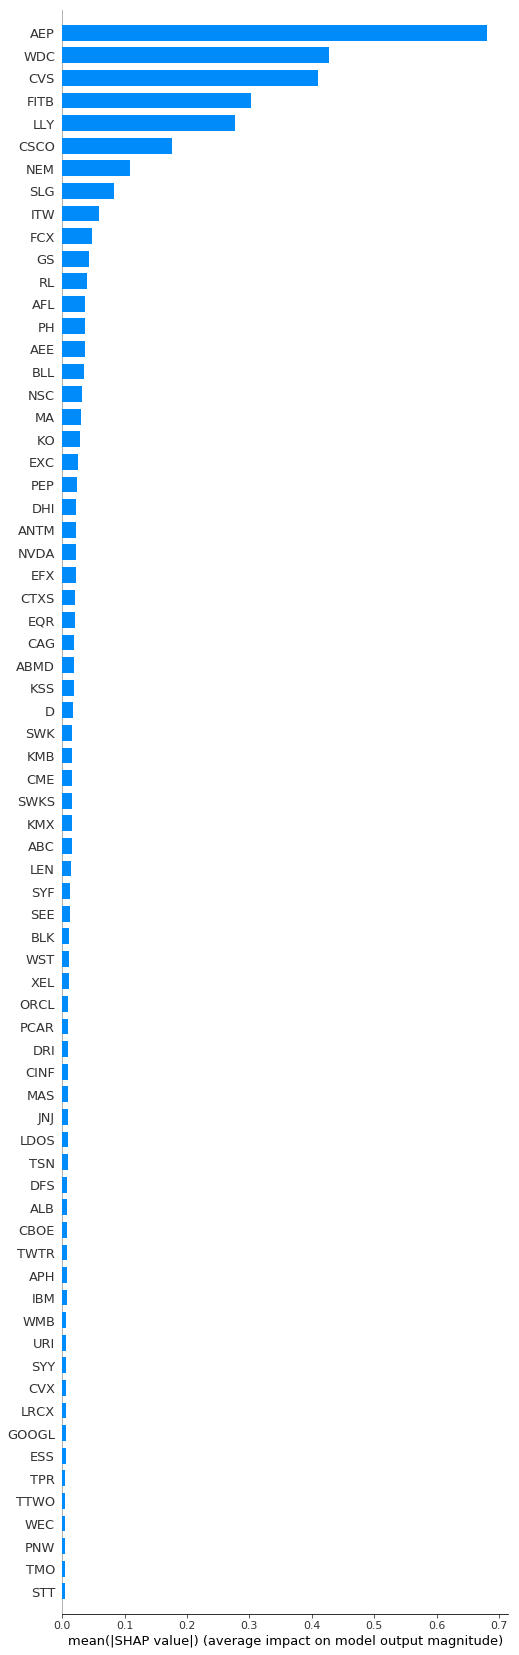

In [17]:
j=4

feature_cols =  df_data.drop(columns=["csi1"]).columns

plot_output = shap.summary_plot(shap_values_XGB_test, X_test, plot_type="bar", feature_names=feature_cols, max_display=70)

In [18]:
feature_imp = pd.DataFrame(xgb_reg.feature_importances_, index=df_data.drop(columns=["csi1"]).columns, columns=["Feature_Importance"])
xgb_columns = feature_imp.sort_values(by=["Feature_Importance"], ascending=False).index.tolist()
print(xgb_columns)

['WDC', 'AEP', 'SLG', 'FITB', 'LDOS', 'MA', 'LUV', 'CAH', 'MTB', 'CDW', 'CVS', 'LKQ', 'CSCO', 'AEE', 'LLY', 'DXC', 'ITW', 'MAS', 'CAG', 'HUM', 'BLL', 'WST', 'NEM', 'TPR', 'EXC', 'TYL', 'FBHS', 'STT', 'PGR', 'NLSN', 'KSS', 'CTXS', 'MYL', 'EQR', 'KMI', 'SNPS', 'ABMD', 'ARE', 'CCL', 'AJG', 'TWTR', 'NSC', 'AMAT', 'DRI', 'BLK', 'PNW', 'D', 'AMP', 'NRG', 'DG', 'PLD', 'TDG', 'KO', 'DOV', 'PEP', 'GOOG', 'ABC', 'LW', 'SBAC', 'FTNT', 'CI', 'PCAR', 'DGX', 'EFX', 'PWR', 'TSN', 'PPL', 'GOOGL', 'HBAN', 'GIS', 'LEN', 'FE', 'CBOE', 'DFS', 'DPZ', 'MHK', 'AZO', 'DHI', 'RSG', 'XEL', 'CNP', 'TEL', 'ANTM', 'AMZN', 'CPB', 'SYF', 'MAA', 'PG', 'WEC', 'MDT', 'SEE', 'OMC', 'GS', 'CF', 'WMT', 'EA', 'TTWO', 'MAR', 'CINF', 'NEE', 'ESS', 'GWW', 'KMX', 'FLT', 'FCX', 'JNJ', 'RL', 'WM', 'CMG', 'BBY', 'AVB', 'LMT', 'PRGO', 'JKHY', 'EXPD', 'HES', 'TMO', 'SYY', 'MTD', 'ILMN', 'ORCL', 'NKE', 'CHTR', 'TGT', 'EBAY', 'WMB', 'FB', 'EIX', 'HBI', 'IT', 'DTE', 'IBM', 'APD', 'APH', 'IPG', 'INFO', 'DVA', 'GM', 'XLNX', 'IVZ', 'CMI'

## F_regression for Feature Selection

In [19]:
F_vals, P_vals = f_regression(X=df_data.drop(columns=["csi1"]).fillna(0).values, 
                              y=df_data["csi1"].values)

p_vals_df = pd.DataFrame(P_vals, index=df_data.drop(columns=['csi1']).columns, columns=["P_values"])
p_vals_df = p_vals_df.sort_values(by=["P_values"])
p_vals_df

,P_values
AEP,2.290180e-254
LLY,1.779992e-147
SWK,2.516723e-126
AEE,8.181053e-106
BLK,1.121390e-101
...,...
KSS,9.276469e-01
CHD,9.387766e-01
VIAC,9.679068e-01
WU,9.787897e-01


# Experiments with Different Tickers Selection Methods and Sizes

## 1. 5 Tickers

### 1.1 Random Tickers

In [20]:
def try_model_on_selected_tickers(df_data, tickers, date):
    df_subset = filter_data(df_data, tickers, date)

    # "Difference" the data (statistics term)
    n_obs = 5 ## Beyond 5 results detriorate for majority of predictions

    # Isolate usable columns and ensure csi1 and csi_difference are in the final list
    final_cols = df_subset.columns 
    # Create training and test data
    X_train, X_test = df_subset[final_cols][0:-n_obs], df_subset[final_cols][-n_obs:]
    X_train_transformed = X_train.diff().dropna()

    # Train model and return predictions and coefficients
    pred, df_coef, lag_order, res = train_model(X_train_transformed, 
                                                X_test,
                                                n_obs, 
                                                verbose = True,
                                                )
    
    output, MSE = make_predictions(X_train, pred, X_test)
    
    print("MSE : %.5f"%MSE)
    print("Lag Order : %d"%lag_order)
    
    return output, res

In [21]:
## If cell with random tickers fails then please run it few times because it selects repeating tickers sometimes.

selected_tickers = ["csi1"] + random.choices(total_snp_tickers, k=5)

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'MET', 'NOW', 'TSCO', 'DTE', 'DD']
Lag samples to use for future predictions :  2
MSE : 0.00554
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.00,1.86,107.56%
3,2019-12-30,1.87,1.79,104.11%
2,2019-12-27,1.74,1.73,100.74%
1,2019-12-26,1.61,1.61,99.56%
0,2019-12-24,1.48,1.44,102.99%


### 1.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [22]:
selected_tickers = ["csi1"] + csi1_x_columns[:5]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD']
Lag samples to use for future predictions :  2
MSE : 0.00830
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.03,1.86,109.24%
3,2019-12-30,1.89,1.79,105.48%
2,2019-12-27,1.76,1.73,101.72%
1,2019-12-26,1.62,1.61,100.21%
0,2019-12-24,1.48,1.44,103.01%


### 1.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [23]:
selected_tickers = ["csi1"] + csi1_y_columns[:5]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT']
Lag samples to use for future predictions :  2
MSE : 0.00152
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.92,1.86,103.44%
3,2019-12-30,1.81,1.79,100.62%
2,2019-12-27,1.69,1.73,97.83%
1,2019-12-26,1.57,1.61,97.33%
0,2019-12-24,1.46,1.44,101.20%


### 1.5 XGB Feature Importance Tickers

In [24]:
selected_tickers = ["csi1"] + xgb_columns[:5]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WDC', 'AEP', 'SLG', 'FITB', 'LDOS']
Lag samples to use for future predictions :  2
MSE : 0.00320
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.97,1.86,105.82%
3,2019-12-30,1.84,1.79,102.68%
2,2019-12-27,1.72,1.73,99.55%
1,2019-12-26,1.59,1.61,98.76%
0,2019-12-24,1.47,1.44,102.28%


### 1.6 Sklearn F_regression P-Values

In [25]:
selected_tickers = ["csi1"] + p_vals_df.index.tolist()[:5]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'AEP', 'LLY', 'SWK', 'AEE', 'BLK']
Lag samples to use for future predictions :  2
MSE : 0.00646
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.01,1.86,108.04%
3,2019-12-30,1.88,1.79,104.53%
2,2019-12-27,1.74,1.73,101.06%
1,2019-12-26,1.61,1.61,99.84%
0,2019-12-24,1.48,1.44,103.05%


## 2. 10 Tickers

### 2.1 Random Tickers

In [26]:
selected_tickers = ["csi1"] + random.choices(total_snp_tickers, k=10)

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'DUK', 'TYL', 'APH', 'KLAC', 'DOV', 'PG', 'EOG', 'CMCSA', 'AWK', 'PAYC']
Lag samples to use for future predictions :  2
MSE : 0.00554
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.00,1.86,107.59%
3,2019-12-30,1.87,1.79,104.14%
2,2019-12-27,1.74,1.73,100.73%
1,2019-12-26,1.61,1.61,99.58%
0,2019-12-24,1.48,1.44,102.90%


### 2.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [27]:
selected_tickers = ["csi1"] + csi1_x_columns[:10]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR']
Lag samples to use for future predictions :  2
MSE : 0.00554
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.00,1.86,107.86%
3,2019-12-30,1.87,1.79,104.35%
2,2019-12-27,1.74,1.73,100.85%
1,2019-12-26,1.61,1.61,99.64%
0,2019-12-24,1.48,1.44,102.75%


### 2.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [28]:
selected_tickers = ["csi1"] + csi1_y_columns[:10]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC']
Lag samples to use for future predictions :  2
MSE : 0.00238
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.95,1.86,104.85%
3,2019-12-30,1.83,1.79,101.83%
2,2019-12-27,1.71,1.73,98.87%
1,2019-12-26,1.58,1.61,98.17%
0,2019-12-24,1.47,1.44,101.96%


### 2.5 XGB Feature Importance Tickers

In [29]:
selected_tickers = ["csi1"] + xgb_columns[:10]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WDC', 'AEP', 'SLG', 'FITB', 'LDOS', 'MA', 'LUV', 'CAH', 'MTB', 'CDW']
Lag samples to use for future predictions :  2
MSE : 0.00320
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.97,1.86,105.86%
3,2019-12-30,1.84,1.79,102.71%
2,2019-12-27,1.72,1.73,99.56%
1,2019-12-26,1.59,1.61,98.77%
0,2019-12-24,1.47,1.44,102.28%


### 2.6 Sklearn F_regression P-Values

In [30]:
selected_tickers = ["csi1"] + p_vals_df.index.tolist()[:10]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'AEP', 'LLY', 'SWK', 'AEE', 'BLK', 'RJF', 'DXC', 'ROK', 'MRK', 'PH']
Lag samples to use for future predictions :  2
MSE : 0.00554
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.00,1.86,107.45%
3,2019-12-30,1.87,1.79,104.02%
2,2019-12-27,1.74,1.73,100.62%
1,2019-12-26,1.61,1.61,99.52%
0,2019-12-24,1.48,1.44,102.73%


## 3. 20 Tickers

### 3.1 Random Tickers

In [31]:
selected_tickers = ["csi1"] + random.choices(total_snp_tickers, k=20)

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'PKI', 'SLB', 'DOV', 'CHTR', 'HD', 'RE', 'A', 'WM', 'RCL', 'ALB', 'SRE', 'PKG', 'ISRG', 'ILMN', 'CCI', 'AIG', 'V', 'HSY', 'LUV', 'ZION']
Lag samples to use for future predictions :  2
MSE : 0.00146
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.92,1.86,103.35%
3,2019-12-30,1.80,1.79,100.55%
2,2019-12-27,1.69,1.73,97.82%
1,2019-12-26,1.57,1.61,97.33%
0,2019-12-24,1.46,1.44,101.30%


### 3.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [32]:
selected_tickers = ["csi1"] + csi1_x_columns[:20]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI']
Lag samples to use for future predictions :  2
MSE : 0.00820
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.03,1.86,109.01%
3,2019-12-30,1.89,1.79,105.34%
2,2019-12-27,1.75,1.73,101.62%
1,2019-12-26,1.62,1.61,100.29%
0,2019-12-24,1.48,1.44,103.14%


### 3.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [33]:
selected_tickers = ["csi1"] + csi1_y_columns[:20]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK']
Lag samples to use for future predictions :  2
MSE : 0.00336
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.97,1.86,106.07%
3,2019-12-30,1.85,1.79,102.88%
2,2019-12-27,1.72,1.73,99.72%
1,2019-12-26,1.60,1.61,98.87%
0,2019-12-24,1.47,1.44,102.51%


### 3.5 XGB Feature Importance Tickers

In [34]:
selected_tickers = ["csi1"] + xgb_columns[:20]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WDC', 'AEP', 'SLG', 'FITB', 'LDOS', 'MA', 'LUV', 'CAH', 'MTB', 'CDW', 'CVS', 'LKQ', 'CSCO', 'AEE', 'LLY', 'DXC', 'ITW', 'MAS', 'CAG', 'HUM']
Lag samples to use for future predictions :  2
MSE : 0.00554
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.00,1.86,107.43%
3,2019-12-30,1.87,1.79,104.06%
2,2019-12-27,1.74,1.73,100.70%
1,2019-12-26,1.61,1.61,99.69%
0,2019-12-24,1.48,1.44,103.06%


### 3.6 Sklearn F_regression P-Values

In [35]:
selected_tickers = ["csi1"] + p_vals_df.index.tolist()[:20]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'AEP', 'LLY', 'SWK', 'AEE', 'BLK', 'RJF', 'DXC', 'ROK', 'MRK', 'PH', 'EIX', 'PVH', 'ITW', 'FE', 'WDC', 'KMX', 'JPM', 'AMP', 'MMM', 'MCHP']
Lag samples to use for future predictions :  2
MSE : 0.00470
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.99,1.86,106.98%
3,2019-12-30,1.86,1.79,103.62%
2,2019-12-27,1.73,1.73,100.33%
1,2019-12-26,1.60,1.61,99.32%
0,2019-12-24,1.48,1.44,102.69%


## 4. 30 Tickers

### 4.1 Random Tickers

In [39]:
selected_tickers = ["csi1"] + random.choices(total_snp_tickers, k=30)

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'VRSK', 'O', 'INFO', 'CHRW', 'NOV', 'UAL', 'SO', 'CCL', 'LYV', 'SRE', 'BLL', 'K', 'F', 'EXC', 'JCI', 'HRB', 'BBY', 'MSCI', 'SNA', 'MAA', 'BKNG', 'INTC', 'NTRS', 'WMB', 'SJM', 'SLG', 'MDT', 'LLY', 'MCO', 'ROP']
Lag samples to use for future predictions :  2
MSE : 0.00716
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.02,1.86,108.60%
3,2019-12-30,1.88,1.79,105.00%
2,2019-12-27,1.75,1.73,101.38%
1,2019-12-26,1.62,1.61,100.16%
0,2019-12-24,1.48,1.44,103.03%


### 4.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [40]:
selected_tickers = ["csi1"] + csi1_x_columns[:30]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT']
Lag samples to use for future predictions :  2
MSE : 0.00890
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.03,1.86,109.40%
3,2019-12-30,1.90,1.79,105.68%
2,2019-12-27,1.76,1.73,101.96%
1,2019-12-26,1.62,1.61,100.57%
0,2019-12-24,1.49,1.44,103.59%


### 4.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [41]:
selected_tickers = ["csi1"] + csi1_y_columns[:30]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'TIF', 'SYK', 'CNP', 'URI', 'SWK', 'AMD', 'CDNS', 'DPZ', 'TXT', 'AMZN']
Lag samples to use for future predictions :  2
MSE : 0.00278
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.96,1.86,105.60%
3,2019-12-30,1.84,1.79,102.47%
2,2019-12-27,1.72,1.73,99.47%
1,2019-12-26,1.59,1.61,98.58%
0,2019-12-24,1.47,1.44,102.50%


### 4.5 XGB Feature Importance Tickers

In [42]:
selected_tickers = ["csi1"] + xgb_columns[:30]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WDC', 'AEP', 'SLG', 'FITB', 'LDOS', 'MA', 'LUV', 'CAH', 'MTB', 'CDW', 'CVS', 'LKQ', 'CSCO', 'AEE', 'LLY', 'DXC', 'ITW', 'MAS', 'CAG', 'HUM', 'BLL', 'WST', 'NEM', 'TPR', 'EXC', 'TYL', 'FBHS', 'STT', 'PGR', 'NLSN']
Lag samples to use for future predictions :  2
MSE : 0.00652
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.01,1.86,108.20%
3,2019-12-30,1.88,1.79,104.68%
2,2019-12-27,1.75,1.73,101.20%
1,2019-12-26,1.61,1.61,100.03%
0,2019-12-24,1.48,1.44,103.26%


### 4.6 Sklearn F_regression P-Values

In [43]:
selected_tickers = ["csi1"] + p_vals_df.index.tolist()[:30]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'AEP', 'LLY', 'SWK', 'AEE', 'BLK', 'RJF', 'DXC', 'ROK', 'MRK', 'PH', 'EIX', 'PVH', 'ITW', 'FE', 'WDC', 'KMX', 'JPM', 'AMP', 'MMM', 'MCHP', 'FDX', 'ALB', 'PPL', 'ARE', 'EBAY', 'ADI', 'ETN', 'DUK', 'EXC', 'F']
Lag samples to use for future predictions :  2
MSE : 0.00382
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.98,1.86,106.36%
3,2019-12-30,1.85,1.79,103.10%
2,2019-12-27,1.72,1.73,99.87%
1,2019-12-26,1.60,1.61,98.98%
0,2019-12-24,1.47,1.44,102.28%


## 5. 40 Tickers

### 5.1 Random Tickers

In [46]:
selected_tickers = ["csi1"] + random.choices(total_snp_tickers, k=40)

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'IRM', 'JNPR', 'PNW', 'CAT', 'MXIM', 'WAB', 'CSX', 'O', 'USB', 'WDC', 'KR', 'INTU', 'CAH', 'LH', 'ABBV', 'KMB', 'FLIR', 'CVX', 'PKG', 'PNC', 'PCAR', 'WYNN', 'ETR', 'HRL', 'DLR', 'CTVA', 'SEE', 'AKAM', 'NEE', 'DFS', 'VAR', 'ALGN', 'CTAS', 'DPZ', 'WY', 'GPC', 'PVH', 'IR', 'CI', 'PEP']
Lag samples to use for future predictions :  2
MSE : 0.00166
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.88,1.86,101.10%
3,2019-12-30,1.77,1.79,98.68%
2,2019-12-27,1.66,1.73,96.35%
1,2019-12-26,1.56,1.61,96.41%
0,2019-12-24,1.45,1.44,100.77%


### 5.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [47]:
selected_tickers = ["csi1"] + csi1_x_columns[:40]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR']
Lag samples to use for future predictions :  2
MSE : 0.00672
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.01,1.86,108.22%
3,2019-12-30,1.88,1.79,104.70%
2,2019-12-27,1.75,1.73,101.22%
1,2019-12-26,1.62,1.61,100.07%
0,2019-12-24,1.49,1.44,103.40%


### 5.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [48]:
selected_tickers = ["csi1"] + csi1_y_columns[:40]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'TIF', 'SYK', 'CNP', 'URI', 'SWK', 'AMD', 'CDNS', 'DPZ', 'TXT', 'AMZN', 'YUM', 'NUE', 'IP', 'PWR', 'LHX', 'PHM', 'RL', 'CLX', 'PKG', 'RE']
Lag samples to use for future predictions :  2
MSE : 0.00228
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.95,1.86,105.11%
3,2019-12-30,1.83,1.79,102.02%
2,2019-12-27,1.71,1.73,99.12%
1,2019-12-26,1.59,1.61,98.20%
0,2019-12-24,1.47,1.44,102.24%


### 5.5 XGB Feature Importance Tickers

In [49]:
selected_tickers = ["csi1"] + xgb_columns[:40]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WDC', 'AEP', 'SLG', 'FITB', 'LDOS', 'MA', 'LUV', 'CAH', 'MTB', 'CDW', 'CVS', 'LKQ', 'CSCO', 'AEE', 'LLY', 'DXC', 'ITW', 'MAS', 'CAG', 'HUM', 'BLL', 'WST', 'NEM', 'TPR', 'EXC', 'TYL', 'FBHS', 'STT', 'PGR', 'NLSN', 'KSS', 'CTXS', 'MYL', 'EQR', 'KMI', 'SNPS', 'ABMD', 'ARE', 'CCL', 'AJG']
Lag samples to use for future predictions :  2
MSE : 0.00228
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.95,1.86,104.76%
3,2019-12-30,1.83,1.79,101.80%
2,2019-12-27,1.71,1.73,98.86%
1,2019-12-26,1.59,1.61,98.28%
0,2019-12-24,1.47,1.44,102.19%


### 5.6 Sklearn F_regression P-Values

In [50]:
selected_tickers = ["csi1"] + p_vals_df.index.tolist()[:40]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'AEP', 'LLY', 'SWK', 'AEE', 'BLK', 'RJF', 'DXC', 'ROK', 'MRK', 'PH', 'EIX', 'PVH', 'ITW', 'FE', 'WDC', 'KMX', 'JPM', 'AMP', 'MMM', 'MCHP', 'FDX', 'ALB', 'PPL', 'ARE', 'EBAY', 'ADI', 'ETN', 'DUK', 'EXC', 'F', 'EMN', 'PEP', 'ETR', 'PKG', 'PXD', 'SO', 'WHR', 'CTSH', 'LKQ', 'MHK']
Lag samples to use for future predictions :  2
MSE : 0.00266
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.96,1.86,105.27%
3,2019-12-30,1.83,1.79,102.19%
2,2019-12-27,1.71,1.73,99.15%
1,2019-12-26,1.59,1.61,98.50%
0,2019-12-24,1.47,1.44,102.03%


## 6. 50 Tickers

### 6.1 Random Tickers

In [59]:
selected_tickers = ["csi1"] + random.choices(total_snp_tickers, k=50)

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'CTXS', 'IEX', 'NI', 'ITW', 'LEG', 'NUE', 'DFS', 'ARE', 'HSY', 'ACN', 'DAL', 'PH', 'TMUS', 'VRSK', 'CAG', 'KMX', 'HBAN', 'PFE', 'IBM', 'HAL', 'ABT', 'LVS', 'MYL', 'ALK', 'AIG', 'SRE', 'TRV', 'SNPS', 'CINF', 'TFX', 'LDOS', 'CTVA', 'HST', 'INTC', 'DVN', 'AIZ', 'COP', 'IQV', 'ROP', 'AVGO', 'GIS', 'DUK', 'ZBH', 'CTL', 'CME', 'FISV', 'KEY', 'HOLX', 'SBAC', 'CAT']
Lag samples to use for future predictions :  2
MSE : 0.01512
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.74,1.86,93.41%
3,2019-12-30,1.65,1.79,92.16%
2,2019-12-27,1.57,1.73,91.04%
1,2019-12-26,1.49,1.61,92.41%
0,2019-12-24,1.40,1.44,97.54%


### 6.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [60]:
selected_tickers = ["csi1"] + csi1_x_columns[:50]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR', 'PRU', 'ECL', 'SLB', 'HRB', 'ADBE', 'MSFT', 'AMP', 'EXC', 'WM', 'DVN']
Lag samples to use for future predictions :  2
MSE : 0.00772
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,2.02,1.86,108.91%
3,2019-12-30,1.89,1.79,105.29%
2,2019-12-27,1.75,1.73,101.68%
1,2019-12-26,1.62,1.61,100.51%
0,2019-12-24,1.49,1.44,103.74%


### 6.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [61]:
selected_tickers = ["csi1"] + csi1_y_columns[:50]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'TIF', 'SYK', 'CNP', 'URI', 'SWK', 'AMD', 'CDNS', 'DPZ', 'TXT', 'AMZN', 'YUM', 'NUE', 'IP', 'PWR', 'LHX', 'PHM', 'RL', 'CLX', 'PKG', 'RE', 'PVH', 'CHRW', 'CINF', 'EMR', 'GRMN', 'PCAR', 'CME', 'LRCX', 'DXC', 'AIZ']
Lag samples to use for future predictions :  2
MSE : 0.00134
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.91,1.86,102.56%
3,2019-12-30,1.79,1.79,99.85%
2,2019-12-27,1.68,1.73,97.34%
1,2019-12-26,1.57,1.61,97.00%
0,2019-12-24,1.45,1.44,101.14%


### 6.5 XGB Feature Importance Tickers

In [62]:
selected_tickers = ["csi1"] + xgb_columns[:50]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WDC', 'AEP', 'SLG', 'FITB', 'LDOS', 'MA', 'LUV', 'CAH', 'MTB', 'CDW', 'CVS', 'LKQ', 'CSCO', 'AEE', 'LLY', 'DXC', 'ITW', 'MAS', 'CAG', 'HUM', 'BLL', 'WST', 'NEM', 'TPR', 'EXC', 'TYL', 'FBHS', 'STT', 'PGR', 'NLSN', 'KSS', 'CTXS', 'MYL', 'EQR', 'KMI', 'SNPS', 'ABMD', 'ARE', 'CCL', 'AJG', 'TWTR', 'NSC', 'AMAT', 'DRI', 'BLK', 'PNW', 'D', 'AMP', 'NRG', 'DG']
Lag samples to use for future predictions :  2
MSE : 0.00138
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.92,1.86,103.43%
3,2019-12-30,1.81,1.79,100.67%
2,2019-12-27,1.69,1.73,97.92%
1,2019-12-26,1.58,1.61,97.63%
0,2019-12-24,1.46,1.44,101.56%


### 6.6 Sklearn F_regression P-Values

In [63]:
selected_tickers = ["csi1"] + p_vals_df.index.tolist()[:50]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'AEP', 'LLY', 'SWK', 'AEE', 'BLK', 'RJF', 'DXC', 'ROK', 'MRK', 'PH', 'EIX', 'PVH', 'ITW', 'FE', 'WDC', 'KMX', 'JPM', 'AMP', 'MMM', 'MCHP', 'FDX', 'ALB', 'PPL', 'ARE', 'EBAY', 'ADI', 'ETN', 'DUK', 'EXC', 'F', 'EMN', 'PEP', 'ETR', 'PKG', 'PXD', 'SO', 'WHR', 'CTSH', 'LKQ', 'MHK', 'PFE', 'URI', 'A', 'DOV', 'NRG', 'JBHT', 'MDLZ', 'D', 'FFIV', 'IPGP']
Lag samples to use for future predictions :  2
MSE : 0.00200
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.94,1.86,104.14%
3,2019-12-30,1.82,1.79,101.26%
2,2019-12-27,1.70,1.73,98.44%
1,2019-12-26,1.58,1.61,98.03%
0,2019-12-24,1.47,1.44,101.95%


## 7. 60 Tickers

### 7.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [64]:
selected_tickers = ["csi1"] + csi1_x_columns[:60]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR', 'PRU', 'ECL', 'SLB', 'HRB', 'ADBE', 'MSFT', 'AMP', 'EXC', 'WM', 'DVN', 'EOG', 'XLNX', 'HST', 'MOS', 'HD', 'AKAM', 'PXD', 'CTAS', 'GOOGL', 'COST']
Lag samples to use for future predictions :  2
MSE : 0.00420
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.98,1.86,106.68%
3,2019-12-30,1.86,1.79,103.39%
2,2019-12-27,1.73,1.73,100.14%
1,2019-12-26,1.60,1.61,99.30%
0,2019-12-24,1.48,1.44,102.70%


### 7.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [65]:
selected_tickers = ["csi1"] + csi1_y_columns[:60]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'TIF', 'SYK', 'CNP', 'URI', 'SWK', 'AMD', 'CDNS', 'DPZ', 'TXT', 'AMZN', 'YUM', 'NUE', 'IP', 'PWR', 'LHX', 'PHM', 'RL', 'CLX', 'PKG', 'RE', 'PVH', 'CHRW', 'CINF', 'EMR', 'GRMN', 'PCAR', 'CME', 'LRCX', 'DXC', 'AIZ', 'BIIB', 'VTR', 'LNC', 'BKNG', 'HD', 'WAB', 'FDX', 'PXD', 'LKQ', 'J']
Lag samples to use for future predictions :  2
MSE : 0.00144
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.89,1.86,101.78%
3,2019-12-30,1.78,1.79,99.19%
2,2019-12-27,1.67,1.73,96.78%
1,2019-12-26,1.56,1.61,96.60%
0,2019-12-24,1.45,1.44,100.82%


### 7.5 XGB Feature Importance Tickers

In [66]:
selected_tickers = ["csi1"] + xgb_columns[:60]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WDC', 'AEP', 'SLG', 'FITB', 'LDOS', 'MA', 'LUV', 'CAH', 'MTB', 'CDW', 'CVS', 'LKQ', 'CSCO', 'AEE', 'LLY', 'DXC', 'ITW', 'MAS', 'CAG', 'HUM', 'BLL', 'WST', 'NEM', 'TPR', 'EXC', 'TYL', 'FBHS', 'STT', 'PGR', 'NLSN', 'KSS', 'CTXS', 'MYL', 'EQR', 'KMI', 'SNPS', 'ABMD', 'ARE', 'CCL', 'AJG', 'TWTR', 'NSC', 'AMAT', 'DRI', 'BLK', 'PNW', 'D', 'AMP', 'NRG', 'DG', 'PLD', 'TDG', 'KO', 'DOV', 'PEP', 'GOOG', 'ABC', 'LW', 'SBAC', 'FTNT']
Lag samples to use for future predictions :  2
MSE : 0.00138
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.92,1.86,103.40%
3,2019-12-30,1.81,1.79,100.62%
2,2019-12-27,1.69,1.73,97.88%
1,2019-12-26,1.58,1.61,97.64%
0,2019-12-24,1.46,1.44,101.41%


### 7.6 Sklearn F_regression P-Values

In [67]:
selected_tickers = ["csi1"] + p_vals_df.index.tolist()[:60]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'AEP', 'LLY', 'SWK', 'AEE', 'BLK', 'RJF', 'DXC', 'ROK', 'MRK', 'PH', 'EIX', 'PVH', 'ITW', 'FE', 'WDC', 'KMX', 'JPM', 'AMP', 'MMM', 'MCHP', 'FDX', 'ALB', 'PPL', 'ARE', 'EBAY', 'ADI', 'ETN', 'DUK', 'EXC', 'F', 'EMN', 'PEP', 'ETR', 'PKG', 'PXD', 'SO', 'WHR', 'CTSH', 'LKQ', 'MHK', 'PFE', 'URI', 'A', 'DOV', 'NRG', 'JBHT', 'MDLZ', 'D', 'FFIV', 'IPGP', 'BXP', 'MU', 'CMI', 'PG', 'SIVB', 'EQR', 'CAH', 'IPG', 'VZ', 'APH']
Lag samples to use for future predictions :  2
MSE : 0.00190
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.94,1.86,104.17%
3,2019-12-30,1.82,1.79,101.27%
2,2019-12-27,1.70,1.73,98.45%
1,2019-12-26,1.58,1.61,97.98%
0,2019-12-24,1.46,1.44,101.85%


## 8. 70 Tickers

### 8.2 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [68]:
selected_tickers = ["csi1"] + csi1_x_columns[:70]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR', 'PRU', 'ECL', 'SLB', 'HRB', 'ADBE', 'MSFT', 'AMP', 'EXC', 'WM', 'DVN', 'EOG', 'XLNX', 'HST', 'MOS', 'HD', 'AKAM', 'PXD', 'CTAS', 'GOOGL', 'COST', 'NKE', 'CTXS', 'MRO', 'ODFL', 'DLR', 'INTU', 'DVA', 'TSN', 'BAC', 'PFE']
Lag samples to use for future predictions :  2
MSE : 0.00190
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.94,1.86,104.59%
3,2019-12-30,1.82,1.79,101.66%
2,2019-12-27,1.70,1.73,98.73%
1,2019-12-26,1.59,1.61,98.24%
0,2019-12-24,1.47,1.44,102.12%


### 8.3 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [69]:
selected_tickers = ["csi1"] + csi1_y_columns[:70]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'TIF', 'SYK', 'CNP', 'URI', 'SWK', 'AMD', 'CDNS', 'DPZ', 'TXT', 'AMZN', 'YUM', 'NUE', 'IP', 'PWR', 'LHX', 'PHM', 'RL', 'CLX', 'PKG', 'RE', 'PVH', 'CHRW', 'CINF', 'EMR', 'GRMN', 'PCAR', 'CME', 'LRCX', 'DXC', 'AIZ', 'BIIB', 'VTR', 'LNC', 'BKNG', 'HD', 'WAB', 'FDX', 'PXD', 'LKQ', 'J', 'GOOGL', 'CSCO', 'MCD', 'COF', 'CF', 'MAS', 'GOOG', 'INTU', 'GIS', 'KSS']
Lag samples to use for future predictions :  2
MSE : 0.00144
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.89,1.86,101.60%
3,2019-12-30,1.78,1.79,99.07%
2,2019-12-27,1.67,1.73,96.65%
1,2019-12-26,1.56,1.61,96.51%
0,2019-12-24,1.45,1.44,100.62%


### 8.5 XGB Feature Importance Tickers

In [70]:
selected_tickers = ["csi1"] + xgb_columns[:70]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'WDC', 'AEP', 'SLG', 'FITB', 'LDOS', 'MA', 'LUV', 'CAH', 'MTB', 'CDW', 'CVS', 'LKQ', 'CSCO', 'AEE', 'LLY', 'DXC', 'ITW', 'MAS', 'CAG', 'HUM', 'BLL', 'WST', 'NEM', 'TPR', 'EXC', 'TYL', 'FBHS', 'STT', 'PGR', 'NLSN', 'KSS', 'CTXS', 'MYL', 'EQR', 'KMI', 'SNPS', 'ABMD', 'ARE', 'CCL', 'AJG', 'TWTR', 'NSC', 'AMAT', 'DRI', 'BLK', 'PNW', 'D', 'AMP', 'NRG', 'DG', 'PLD', 'TDG', 'KO', 'DOV', 'PEP', 'GOOG', 'ABC', 'LW', 'SBAC', 'FTNT', 'CI', 'PCAR', 'DGX', 'EFX', 'PWR', 'TSN', 'PPL', 'GOOGL', 'HBAN', 'GIS']
Lag samples to use for future predictions :  2
MSE : 0.00116
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.90,1.86,102.52%
3,2019-12-30,1.79,1.79,99.90%
2,2019-12-27,1.68,1.73,97.29%
1,2019-12-26,1.57,1.61,97.20%
0,2019-12-24,1.45,1.44,101.10%


In [71]:
#res.stderr[["csi1"]].T

### 8.6 Sklearn F_regression P-Values

In [72]:
selected_tickers = ["csi1"] + p_vals_df.index.tolist()[:70]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['csi1', 'AEP', 'LLY', 'SWK', 'AEE', 'BLK', 'RJF', 'DXC', 'ROK', 'MRK', 'PH', 'EIX', 'PVH', 'ITW', 'FE', 'WDC', 'KMX', 'JPM', 'AMP', 'MMM', 'MCHP', 'FDX', 'ALB', 'PPL', 'ARE', 'EBAY', 'ADI', 'ETN', 'DUK', 'EXC', 'F', 'EMN', 'PEP', 'ETR', 'PKG', 'PXD', 'SO', 'WHR', 'CTSH', 'LKQ', 'MHK', 'PFE', 'URI', 'A', 'DOV', 'NRG', 'JBHT', 'MDLZ', 'D', 'FFIV', 'IPGP', 'BXP', 'MU', 'CMI', 'PG', 'SIVB', 'EQR', 'CAH', 'IPG', 'VZ', 'APH', 'CXO', 'ESS', 'MAR', 'FMC', 'LRCX', 'T', 'ED', 'NTAP', 'CE', 'AMAT']
Lag samples to use for future predictions :  2
MSE : 0.00190
Lag Order : 2


,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.94,1.86,104.55%
3,2019-12-30,1.82,1.79,101.61%
2,2019-12-27,1.70,1.73,98.71%
1,2019-12-26,1.59,1.61,98.20%
0,2019-12-24,1.47,1.44,102.03%
